# Imports

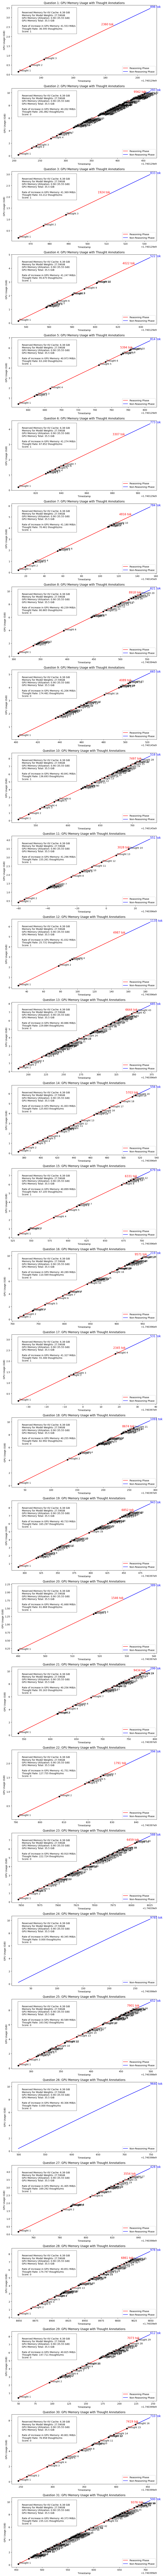

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

GPU_MEM_TOTAL = 35.50 # Total GPU memory in GiB

# Read token counts which contains the reasoning tokens counts for each question.
token_counts_path = '/home/colin/vllm/scratch/token_counts.csv'
df_counts = pd.read_csv(token_counts_path)

# Determine the number of questions based on the number of rows in token_counts.csv
num_questions = len(df_counts)

# Prepare filenames for each question CSV (the file has a header row with timestamp,gpu_cache_usage_sys)
question_files = [f'/home/colin/vllm/scratch/kvcache_usages/question_{i}.csv' for i in range(1, num_questions + 1)]

# Create a subplot for each question
fig, axes = plt.subplots(num_questions, 1, figsize=(10, 5 * num_questions), squeeze=False)

for idx, file in enumerate(question_files):
    ax = axes[idx][0]
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_sys'].values * GPU_MEM_TOTAL

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    non_reasoning_count = len(timestamps) - reasoning_count

    # Compute the overall duration
    total_time = float(timestamps[-1]) - float(timestamps[0])
    if total_time > 0:
        gpu_rate = (usage[-1] - usage[0]) / total_time * 1024
    else:
        gpu_rate = 0

    # Convert thought positions string to a list and compute thought rate.
    thought_positions_str = df_counts.loc[idx, 'Thought Positions']
    thought_positions = ast.literal_eval(thought_positions_str)
    if total_time > 0:
        thought_rate = len(thought_positions) / total_time * 1000 # Convert to thoughts/ms
    else:
        thought_rate = 0

    gpu_info_labels = f"""
    Reserved Memory for KV Cache: 6.38 GiB
    Memory for Model Weights: 27.59GiB
    GPU Memory Utilization: 0.90 (35.55 GiB)
    GPU Memory Total: {GPU_MEM_TOTAL} GiB

    Rate of increase in GPU Memory: {gpu_rate:.3f} MiB/s
    Thought Rate: {thought_rate:.3f} thoughts/ms
    Score: {df_counts.loc[idx, 'Score']}"""

    # Label the rates on the graph (placed in the upper left corner)
    ax.text(0.05, 0.95,
            gpu_info_labels,
            transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, pad=5))

    # Plot reasoning phase (first reasoning_count rows) in red.
    if reasoning_count > 0:
        ax.plot(timestamps[:reasoning_count], usage[:reasoning_count],
                color='red', label='Reasoning Phase')
        ax.text(timestamps[reasoning_count - 1], usage[reasoning_count - 1],
                f'{reasoning_count} tok', color='red', fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')

    # Plot non-reasoning phase (remaining rows) in blue.
    if reasoning_count < len(timestamps):
        ax.plot(timestamps[reasoning_count:], usage[reasoning_count:],
                color='blue', label='Non-Reasoning Phase')
        ax.text(timestamps[-1], usage[-1],
                f'{non_reasoning_count} tok', color='blue', fontsize=12,
                verticalalignment='bottom', horizontalalignment='left')

    # Mark and annotate each thought position from token_counts.csv
    for j, pos in enumerate(thought_positions):
        # Ensure pos is within bounds (skip if not)
        if pos < len(timestamps):
            ts = timestamps[pos]
            usage_val = usage[pos]
            ax.plot(ts, usage_val, 'ko', markersize=6)  # Mark with a black dot
            ax.text(ts, usage_val, f' Thought {j+1}', color='black', fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('GPU Usage (GiB)')
    ax.set_title(f'Question {idx+1}: GPU Memory Usage with Thought Annotations')
    ax.legend()

plt.tight_layout()
plt.show()

# Box plot of total KV cache usage (reasoning part) vs. Thought Count

/tmp/ipykernel_1741319/2215056108.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted_keys, patch_artist=True)


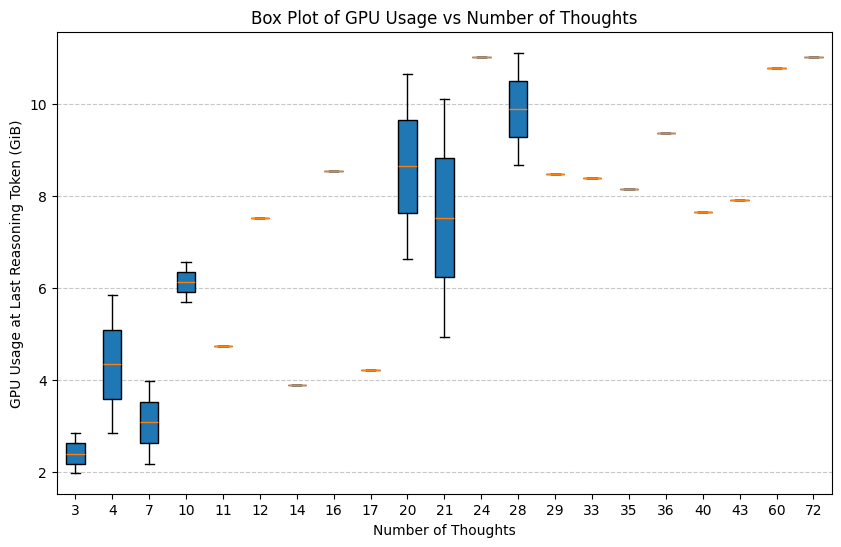

In [18]:
# Begin new cell or append to your notebook
import matplotlib.pyplot as plt

# Dictionary to group GPU usage values by the number of thoughts.
grouped_usage = {}

for idx, file in enumerate(question_files):
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_sys'].values * GPU_MEM_TOTAL

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    
    # Only process if there is a reasoning phase
    if reasoning_count > 0:
        # GPU usage at the last token for the reasoning phase.
        last_gpu_usage = usage[reasoning_count - 1]
        
        # Get number of thoughts for this question.
        thought_positions_str = df_counts.loc[idx, 'Thought Positions']
        thought_positions = ast.literal_eval(thought_positions_str)
        num_thoughts = len(thought_positions)
        
        # Group by num_thoughts.
        grouped_usage.setdefault(num_thoughts, []).append(last_gpu_usage)

# Prepare data for the boxplot.
# Sort the groups by the number of thoughts.
sorted_keys = sorted(grouped_usage.keys())
data = [grouped_usage[k] for k in sorted_keys]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=sorted_keys, patch_artist=True)
plt.xlabel('Number of Thoughts')
plt.ylabel('GPU Usage at Last Reasoning Token (GiB)')
plt.title('Box Plot of GPU Usage vs Number of Thoughts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculations

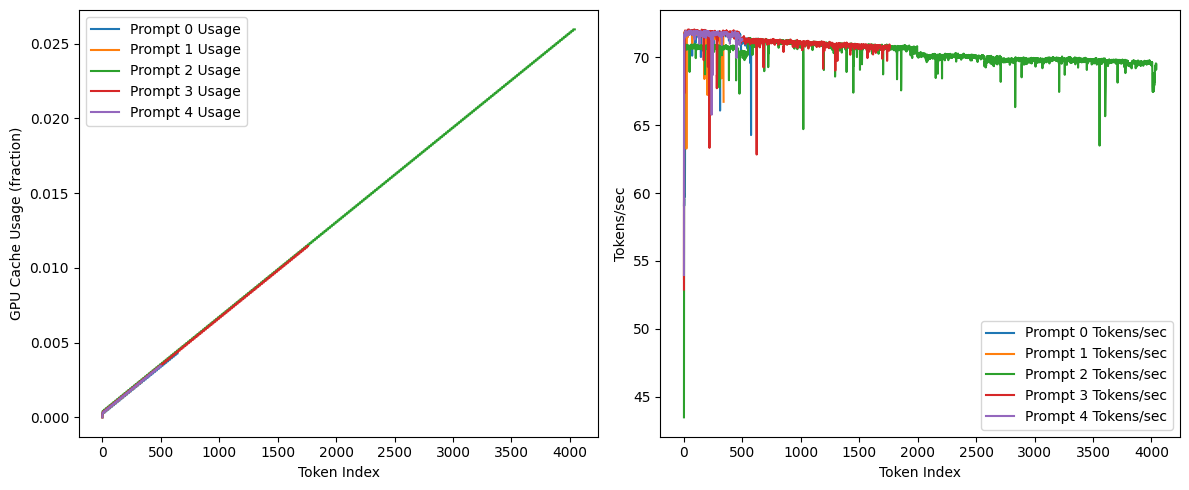

In [ ]:
# # List of CSV filenames
# filenames = [f'kvcache_usage_{i}.csv' for i in range(1, 6)]

# plt.figure(figsize=(12, 5))
# ax1 = plt.subplot(1, 2, 1)  # Usage plot
# ax2 = plt.subplot(1, 2, 2)  # Tokens/sec plot

# for i in range(len(filenames)):
#     df = pd.read_csv(filenames[i])
#     timestamps = df['timestamp'].values
#     usage = df['gpu_cache_usage_sys'].values

#     # Compute tokens per second by taking differences of timestamps
#     # Avoid division by zero by ensuring no time diff is 0.
#     time_diffs = np.diff(timestamps)
#     tokens_per_sec = 1.0 / time_diffs

#     ax1.plot(usage, label=f'Prompt {i} Usage')
#     ax2.plot(tokens_per_sec, label=f'Prompt {i} Tokens/sec')

# ax1.set_xlabel('Token Index')
# ax1.set_ylabel('GPU Cache Usage (fraction)')
# ax1.legend()
# ax2.set_xlabel('Token Index')
# ax2.set_ylabel('Tokens/sec')
# ax2.legend()

# plt.tight_layout()
# plt.show()